# Методы сжатия и обработки видео

Полезные ссылки:
* [Telegram-канал](https://t.me/vgcourse)
* [Документация pybind](https://pybind11.readthedocs.io/en/stable/)

Понадобится для работы:
* Pybind11: `conda install -c conda-forge pybind11` (если у вас [Anaconda](www.anaconda.com) или `pip install pybind11`)
* Opencv2: `conda install -c conda-forge opencv` или `pip install opencv-python`) 
* C++ компилятор  

*Если у вас не заработало что-то, смело пишите в чатик курса*

## Задание 3. Motion Estimation ##

Шаблон для выполнения задания состоит из нескольких частей

1. Библиотека ME на C/C++, компилируемая для использования в python-коде. В основном писать код вам придётся именно в библиотеке. Чтобы скомпилировать библиотеку, запустите команду `python3 setup.py build_ext -i` в  корне папки с заданием. *Замечание. Это библиотека компилируется под C++, но внутри вам ничего не мешает писать код на чистом C.*
2. Ipython notebook для тестирования библиотеки. Используйте этот код для оценки качества работы программы и её улучшения.

### 1. Основная часть ###

Оценка качества работы алгоритма будет производиться следующим образом: на основе поля ME между двумя кадрами будет построен восстановленный кадр. Для оценивания качества будет использоваться PSNR между восстановленным и исходным кадром:

<img src="images/me_example.png">

<img src="images/how_it_works.png">

Кроме того, ещё одним параметром работы будет являться **скорость работы**.

In [1]:
# Импортируем нужные библиотеки
import cv2
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
%matplotlib inline

In [2]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [3]:
def show_pair_frames(compensated_frame, frame, psnr_value):
    fig = plt.figure(figsize=(16,7))
    plt.suptitle('Значение PSNR: {:.4f}'.format(psnr_value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(compensated_frame, cmap='gray')
    ax.set_title("Скомпенсированный кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
def visualize_motion_vectors(img, ofs, block_size=16):
    ver, hor = ofs[0], ofs[1]
    ver = cv2.resize(ver, (ver.shape[1] // block_size, ver.shape[0] // block_size))
    hor = cv2.resize(hor, (hor.shape[1] // block_size, hor.shape[0] // block_size))

    height, width = ver.shape

    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    xx = block_size * (xx + 0.5)
    yy = block_size * (yy + 0.5)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img, cmap='gray', alpha=0.5)
    plt.quiver(xx, yy, hor, -ver)
    plt.xticks([])
    plt.yticks([])

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Простая функция для тестирования ME.
def test_me(source_video, me, return_frames=False, result_path=None, return_ofs=False):
    ssim = []
    psnr = []
    speed = []
    compensated_frames = []
    source_frames = []
    ofs = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for frame, prev_frame in pbar:
        start = time.time()
        result = me.Estimate(frame, prev_frame) # Запускаем me
        end = time.time()
        speed.append((end - start) * 1000)
        compensated_frame = result.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            source_frames.append(frame)
        if return_ofs:
            ofs.append(result.ConvertToOF())
        
        
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
        
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'source_frames': source_frames,
        'ofs': ofs
    }

## Ваше решение

- В качестве решения вы должны прикрепить класс ниже.
- Менять прототипы для init и Estimate **нельзя**.
- **Должен** быть возможен вызов вида `test_me(video, me)`.

In [6]:
# GRADED CELL: MotionEstimator

class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        # На данный момент в me_estimator реализован полный перебор - смотреть MotionEstimator::CEstimate
        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)

    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)

**Если вы делали какие-то изменения, то не забудьте перезагрузить модуль. Для этого нажмите Kernel->Restart**

Чтобы проверить, как работет библиотека, давайте проверим его на одной последовательности на самом хорошем качестве.  
*То, что Ваше ME будет по качеству работать хуже полного перебора - это норма. Ваша задача - достаточно сильно ускорить ME, он должен работать ориентировочно за 5-10 мс на кадр. Ориентировочная точка - одно из самых лучших решений прошлого года на среднем ноутбуке показало **5.06ms и 35.1 psnr** на качестве 100.*

In [7]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

/var/folders/70/1q8rzl2n1x718zmjtf5zjp5m0000gp/T/ipykernel_14294/3918991804.py:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))


Посмотрим на то, как компенсируется произвольный кадр:

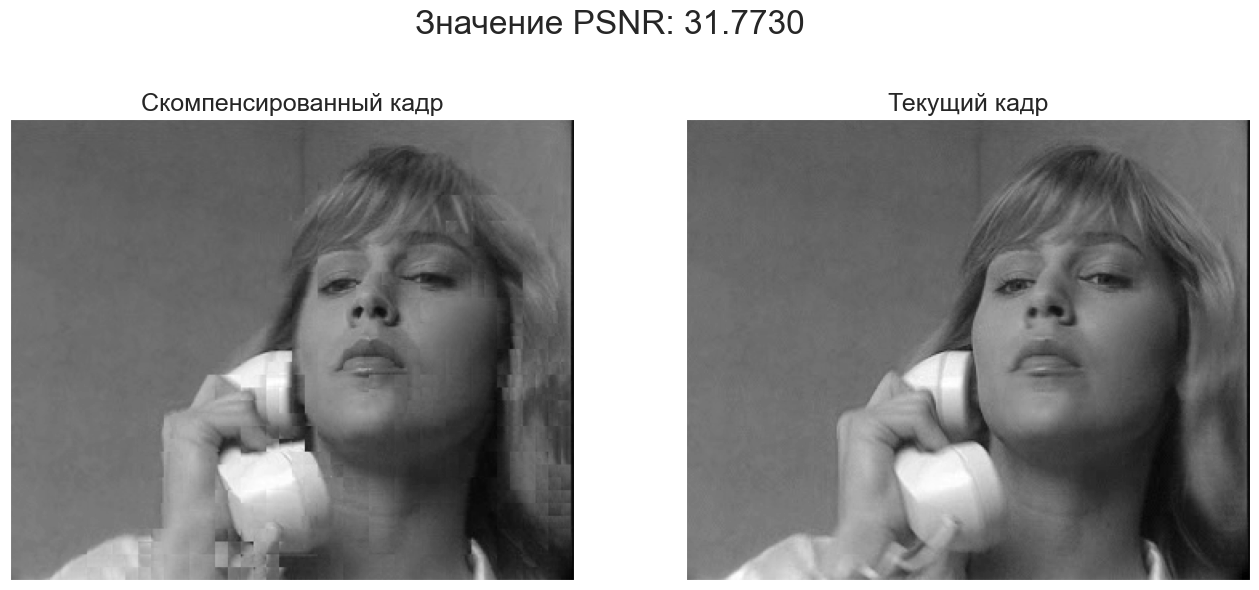

In [8]:
frame_idx = 25
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

Посмотрим на найденные вектора движения

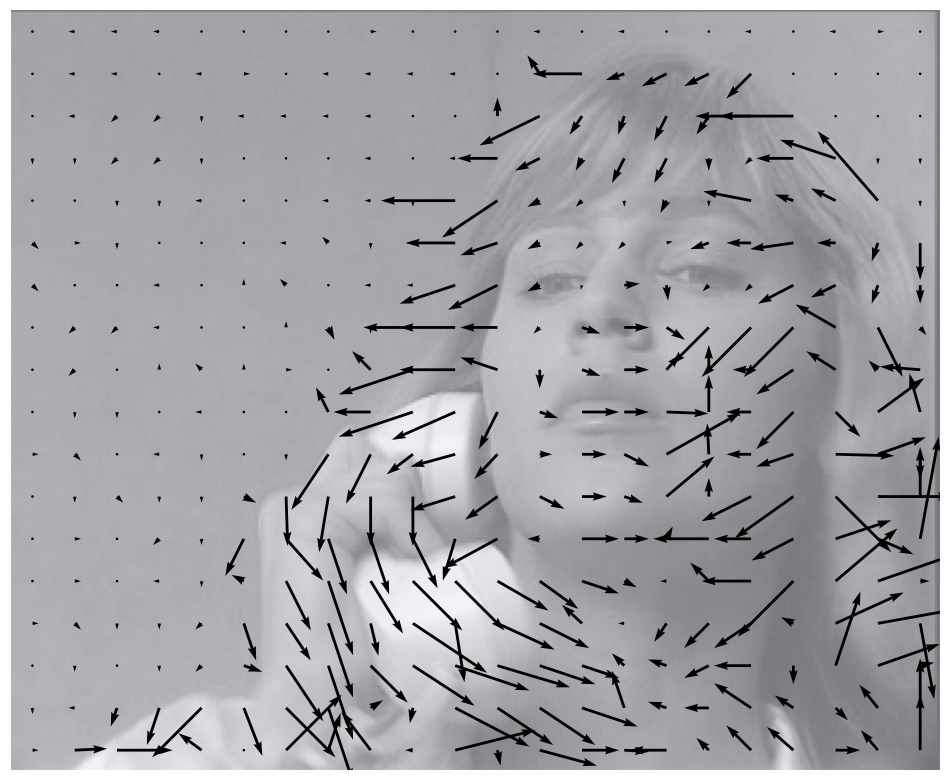

In [9]:
visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx]
)

Примером ниже можно посмотреть графики, как покадрово работает ваш алгоритм. 

<Figure size 1200x600 with 0 Axes>

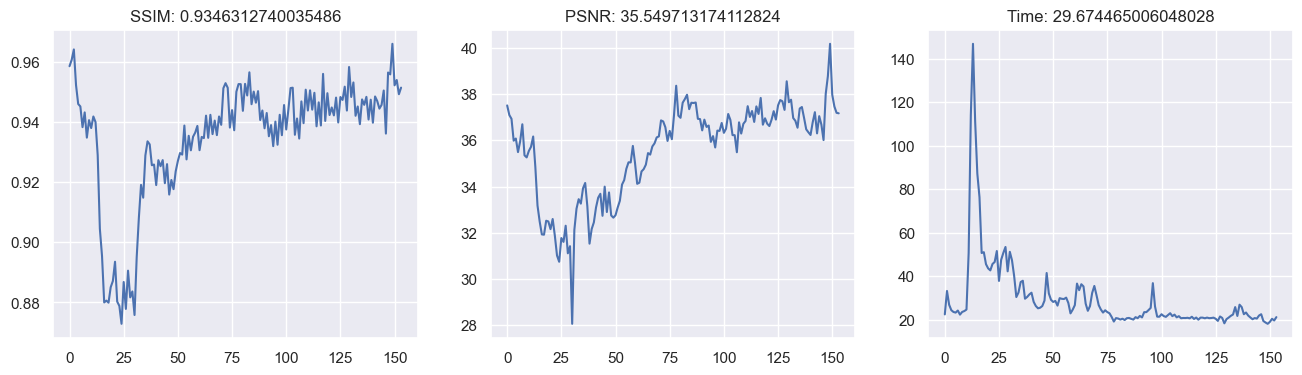

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

In [11]:
import pandas as pd

def test_all_me(video_paths=['source.avi'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in metrics
                        }
                    }
                )
    return pd.DataFrame(result)

In [12]:
result_all = test_all_me(
    video_paths=['video/source.avi'],
    qualities=[100, 80, 60, 40, 20],
    halfpixels=[False, True]
)

0it [00:00, ?it/s]

/var/folders/70/1q8rzl2n1x718zmjtf5zjp5m0000gp/T/ipykernel_14294/3918991804.py:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
/Users/leonidburtsev/Downloads/solution_template/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leonidburtsev/Downloads/solution_template/venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
result_all

,video,halfpixel,quality,ssim,psnr,speed,compensated_frames,source_frames,ofs
0,video/source.avi,False,100,0.934631,35.549713,29.847044,NaN,NaN,NaN
1,video/source.avi,False,80,0.931346,35.246391,14.061135,NaN,NaN,NaN
2,video/source.avi,False,60,0.920659,34.466301,6.220316,NaN,NaN,NaN
3,video/source.avi,False,40,0.918123,34.277968,4.492599,NaN,NaN,NaN
4,video/source.avi,False,20,0.914245,34.010151,4.923732,NaN,NaN,NaN
5,video/source.avi,True,100,0.942806,36.001289,96.886771,NaN,NaN,NaN
6,video/source.avi,True,80,0.939780,35.762303,83.114212,NaN,NaN,NaN
7,video/source.avi,True,60,0.930082,35.057280,27.944251,NaN,NaN,NaN
8,video/source.avi,True,40,0.927700,34.903610,17.604294,NaN,NaN,NaN
9,video/source.avi,True,20,0.924079,34.635363,14.523873,NaN,NaN,NaN


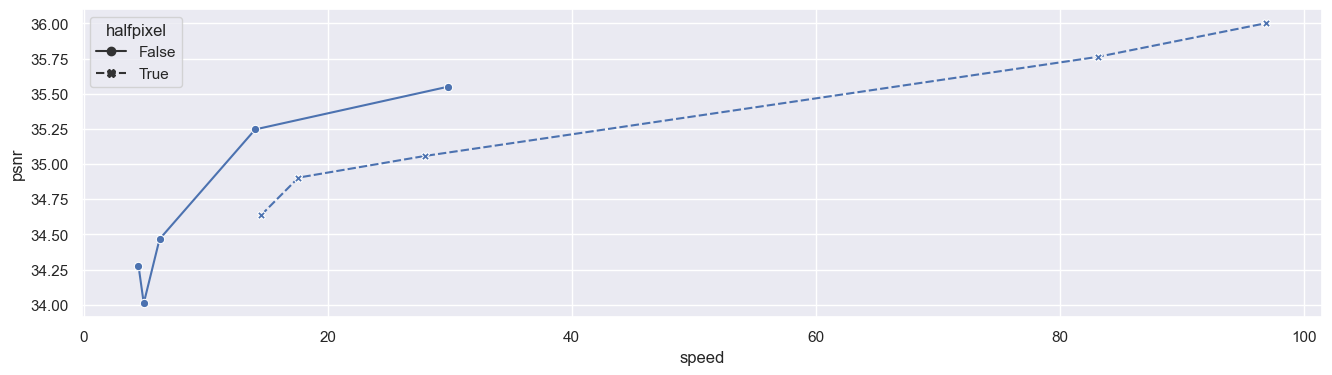

In [14]:
fig, axes = plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)

## 2. Красивый вид кривых скорость/качество ##

*Это бонусное задание, за него вы получите баллы независимо от результатов в конкурсе*

Что хочется увидеть: у ME есть два ключевых параметра, определяющих его "хорошесть" - это скорость работы и качество сопоставления. Очевидно, можно написать метод, который делает полный перебор - он будет лучшим по качеству, но медленным, или наоборот - ничего не сопоставляем: ужасное качество, но замечательная скорость, Хочется, чтобы ваш алгоритм позволял варьировать скорость и качество и не уходил в такие крайности. Ниже пример кривых, которые были в прошлом году - хочется, чтобы форма кривых была как можно ближе к синей c треугольниками:

<img src="images/curves.png">

## 3. Опиши что было сделано ##

*Это тоже небольшое бонусное задание*  
Пожалуйста, опиши (кратко) суть твоего алгоритма, какие алгоритмы за основу ты взял и что решил улучшить.  
Также было бы неплохо, если ты приложишь графики, которые показывают, как каждое улучшение срабатывало.  
Если хочешь, можешь здесь вести небольшой дневник - какие эксперименты ты проводил, какие у тебя были гипотезы и какие у тебя получались результаты

In [15]:
Я реализовал "Three step", получил разный psnr на тестах. Я изменяю количество перебираемых пикселей и количество проходов, благодаря чему меняется psnr.

SyntaxError: invalid syntax (3732161308.py, line 1)

## 4. Немного подсказок

* Напишите сначала какой-нибудь базовый алгоритм, который будет вашим бейзлайном. Затем вы будете его постепенно улучшать
* После этого тестируйте каждое улучшение (одно улучшние - один эксперимент), чтобы не добавить в алгоритм то, что на самом деле ухушает алгоритм
* Не стесняйтесь проводить всякие эксперименты вне кода. Например, можно самостоятельно построить пример рельефа ошибки при сопоставлении, смотреть, насколько близки вектора у соседних блоков, исследовать стабильность векторов блоков по времени. Это позволит каждому улучшению работать максимально эффективно.

## 5. Что такое halfpixel

Пусть нам дан кадр размера 3x2 и мы нашли вектор движения на целочисленной сетке (на рисунке cерая). Чтобы уточнить результат, можно перейти к полупиксельной точности. Интерполируем значения пикселей в нецелых координатах (белых).

<img src="images/halfpixel1.png">
Чтобы избежать работы с в нецелых координатах, будем представлять изображение в два раза большим, а все координаты целыми. Теперь найдем вектор сдвига на полученной сетке. Разделив его на два по каждой координате, мы перейдем назад к неинтерполированным координатам.

В шаблоне уже реализована функция `generate_subpixel_arrays`. По входному кадру она генерирует выходной интерполированный. Интерполированный кадр хранится особым образом: это четыре массива `original`, `left`, `upper`, `upper left`, содержащие соответсвующие интерполированные пиксели. На рисунке изображен пример для кадра размера 3x2.

<img src="images/halfpixel2.png">

Все кадры хранятся в виде одномерного массива. Доступ к конкретному пикселю осуществляется по формуле `y * width + x`. Кроме того для удобства каждый кадр окружен рамками — не придется заботиться о граничных условиях, но поменяется формула досутпа к пикселю. Все необходимые для этого смещения уже реализованы в бейзлайне.